In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from PIL import Image
from tqdm import tqdm
from scipy.signal import correlate2d
import cv2
from scipy import ndimage, datasets
import time

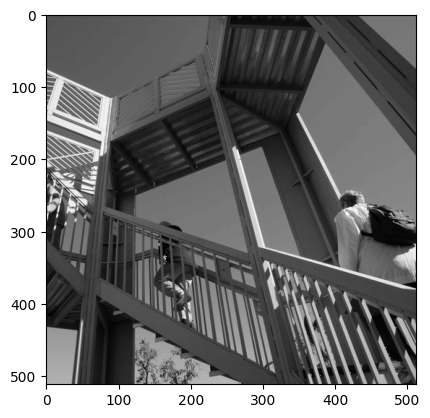

In [33]:
PATCH_SIZE = 7
HALF_SIZE = PATCH_SIZE // 2

PATCH_REGION = lambda i, j : (slice(i - HALF_SIZE, i + HALF_SIZE + 1), \
                              slice(j - HALF_SIZE, j + HALF_SIZE + 1))

SOBEL_X = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])

SOBEL_Y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1],
])

def grad(img_pt):
    assert img_pt.shape == SOBEL_X.shape

    yh, xh = 1, 1
    grad_x = np.sum(img_pt * SOBEL_X)
    grad_y = np.sum(img_pt * SOBEL_Y)

    gradient = np.array([grad_x, grad_y])
    norm = (np.linalg.norm(gradient))
    
    if norm > 0:
        unit_grad = gradient / norm
    else:
        unit_grad = gradient

    return unit_grad, norm

ascent = datasets.ascent().astype('int32')
plt.imshow(ascent, cmap='gray')

In [34]:
class MaskWithBoundary:
    def __init__(self, mask):
        self.array = mask
        self.init_boundary_pixels()

    def __getitem__(self, idx):
        return self.array[idx]

    def init_boundary_pixels(self):
        height, width = self.array.shape
        self.boundary_pixels = set()

        for i in range(height):
            for j in range(width):
                if self.array[i, j]: continue

                if i == 0 or i == height - 1 or j == 0 or j == width - 1:
                    self.boundary_pixels.add((i, j))

                elif self.array[i - 1, j] or self.array[i + 1, j] or self.array[i, j - 1] or self.array[i, j + 1]:
                    self.boundary_pixels.add((i, j))
        
    def update_boundary_pixels(self, i, j):
        # iterate through edges of patch centered at i, j
        for k in range(-HALF_SIZE, HALF_SIZE + 1):
            if not self.array[i + k, j - HALF_SIZE - 1]:
                self.boundary_pixels.add((i + k, j - HALF_SIZE - 1))
            if not self.array[i + k, j + HALF_SIZE + 1]:
                self.boundary_pixels.add((i + k, j + HALF_SIZE + 1))
            if not self.array[i - HALF_SIZE - 1, j + k]:
                self.boundary_pixels.add((i - HALF_SIZE - 1, j + k))
            if not self.array[i + HALF_SIZE + 1, j + k]:
                self.boundary_pixels.add((i + HALF_SIZE + 1, j + k))

    def fill_patch(self, i, j):
        patch_region = PATCH_REGION(i, j)
        idxs = [(i + y, j + x) for x in range(-HALF_SIZE, HALF_SIZE + 1) for y in range(-HALF_SIZE, HALF_SIZE + 1)]
        self.boundary_pixels -= set(idxs)
        
        self.array[patch_region] = True
        self.update_boundary_pixels(i, j)

    def empty(self):
        return len(self.boundary_pixels) == 0
    
    def render_boundary(self):
        mask_with_boundary = 255 * self.array.copy().astype(np.uint32)

        for (i, j) in self.boundary_pixels:
            mask_with_boundary[i, j] = 128

        plt.imshow(mask_with_boundary, cmap='grey')
        plt.show()

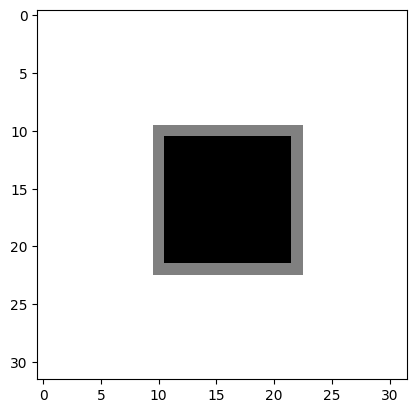

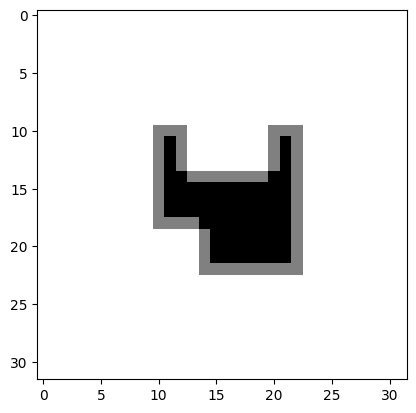

array([0, 0])

In [35]:
mask = np.ones((32, 32), dtype=bool)
mask[10:23, 10:23] = False

mask_with_boundary = MaskWithBoundary(mask)
mask_with_boundary.render_boundary()

mask_with_boundary.fill_patch(10, 16)
mask_with_boundary.fill_patch(22, 10)

# mask_with_boundary.array[21, 10] = 200
mask_with_boundary.render_boundary()

xh, yh = 1, 1
img_pt = mask_with_boundary.array[21 - yh:21 + yh + 1, 10 - xh:10 + xh + 1]
gradient, norm = grad(img_pt)

gradient

In [36]:
def overlay_mask_image(mask_with_boundary, image, pxs=[], show=True):
    mask_integer = mask_with_boundary.array.astype(np.uint8)
    mask_array = 255 * np.stack((mask_integer,) * 3, axis=-1)
    rgb_image = np.stack((image,) * 3, axis=-1)

    for (i, j) in pxs:
        rgb_image[i, j] = np.array([0, 0, 255])

    # Blend the image and the mask
    all_mask_pixels = [(i, j) for i in range(mask.shape[0]) for j in range(mask.shape[1]) if not mask[i, j]]
    interior_rows = [r for (r, _) in all_mask_pixels]
    interior_cols = [c for (_, c) in all_mask_pixels]
    rgb_image[interior_rows, interior_cols] = [255, 255, 255]

    bounday_pixels = list(mask_with_boundary.boundary_pixels)
    boundary_rows = [r for (r, _) in bounday_pixels]
    boundary_cols = [c for (_, c) in bounday_pixels]
    rgb_image[boundary_rows, boundary_cols] = [255, 0, 0]

    if show:
        plt.imshow(rgb_image.astype(np.uint32))
        plt.show()
    else: return rgb_image.astype(np.uint32)

In [55]:
class ObjectRemove:
    def __init__(self, patch_size, image):
        self.patch_size = patch_size
        self.patch_area = self.patch_size ** 2

        self.half_size = patch_size // 2
        self.image = image.astype(np.float32)
        self.height, self.width = self.image.shape

        self.padded_image = np.pad(self.image, self.half_size, mode='edge')
        self.padded_height, self.padded_width = self.padded_image.shape[0], self.padded_image.shape[1]

        self.sx = ndimage.sobel(self.image, axis=0)
        self.sy = ndimage.sobel(self.image, axis=1)

        self.sx_rot = ndimage.rotate(self.sx, 90)
        self.sy_rot = ndimage.rotate(self.sx, 90)

        self.ALPHA = 255

    def clamp_idx(self, ij):
        i, j = ij

        return [
            min(self.height - self.half_size - 1, max(self.half_size, i)),
            min(self.width - self.half_size - 1, max(self.half_size, j))
        ]

    def compute_priority(self, patch_coords, confidence_table, mask):
        i, j = patch_coords
        patch_region = PATCH_REGION(i, j)

        image_3filter = self.image[i-1:i+2, j-1:j+2]
        mask_3filter = mask[i-1:i+2, j-1:j+2]

        confidence = np.sum(mask[patch_region] * confidence_table[patch_region], dtype=float)
        confidence /= self.patch_area

        (img_grad_x, img_grad_y), img_grad_norm = grad(image_3filter)
        boundary_normal, boundary_grad_norm = grad(mask_3filter)
        
        isophote = img_grad_norm * np.array([-img_grad_y, img_grad_x])

        data = abs(np.dot(isophote, boundary_normal))
        data /= self.ALPHA

        return confidence, data
    
    def compute_distance(self, patch_coords, exemp_coords, mask):
        ip, jp = patch_coords
        ie, je = exemp_coords

        patch_region = PATCH_REGION(ip, jp)
        exemp_region = PATCH_REGION(ie, je)

        patch_mask = mask[patch_region]
        patch_mask_sum = np.sum(patch_mask, dtype=float)
        patch_mask_not_sum = np.sum(~patch_mask, dtype=float)

        # compute MSD
        M_p = patch_mask * self.image[patch_region]
        M_e = patch_mask * self.image[exemp_region]

        msd = np.sum((M_p - M_e) ** 2, dtype=float)
        msd /= patch_mask_sum

        # compute SMD
        smd1 = np.sum(patch_mask * self.image[patch_region], dtype=float)
        smd2 = np.sum(~patch_mask * self.image[exemp_region], dtype=float)

        smd1 /= patch_mask_sum
        smd2 /= patch_mask_not_sum

        smd = (smd1 - smd2) ** 2

        return msd + smd

    def fill_region(self, mask, n_exemplar_samples=10):
        assert mask.array.shape[0] == self.image.shape[0] and mask.array.shape[1] == self.image.shape[1]
        max_dim = max(self.image.shape)

        frame_sequence = []
        fig, ax = plt.subplots()
        im = ax.imshow(overlay_mask_image(mask, self.image, show=False), cmap='viridis', interpolation='none')
            
        timing_specs = {
            'priorities': [0, 0],
            'exemplar': [0, 0],
            'fill': [0, 0],
        }

        # initialize confidence table to 0 for masked pixels, 1 for unmasked pixels
        confidence_table = mask.array.copy().astype(np.float32)
        n_iters = 0

        while not mask.empty():
            n_iters += 1

            start_time = time.time()

            priorities = {(i, j) : self.compute_priority((i, j), confidence_table, mask) for (i, j) in mask.boundary_pixels}
            ip, jp = max(priorities, key=lambda x: priorities[x][0] *  priorities[x][1])

            end_time = time.time()
            timing_specs['priorities'][1] = max(timing_specs['priorities'][1], end_time - start_time)
            timing_specs['priorities'][0] += end_time - start_time

            start_time = time.time()
            
            patch_region = PATCH_REGION(ip, jp)
            mask_region = mask[patch_region]            
            masked_patch_region = mask_region * self.image[patch_region]

            max_confidence, _ = priorities[(ip, jp)]

            exemplar_distance = float('inf')
            exemplar_i, exemplar_j = None, None
            n_candidates = 0
            
            while n_candidates < 100:
                s = 2
                offset = np.random.multivariate_normal([0, 0], [[max_dim / s, 0], [0, max_dim / s]])
                i, j = ip + int(offset[0]), jp + int(offset[1])
                
                ic, jc = self.clamp_idx((i, j))
                exemplar_region_c = PATCH_REGION(ic, jc)

                if np.sum(mask[exemplar_region_c]) == self.patch_area:
                    n_candidates += 1

                    c_exemplar_distance = self.compute_distance((ip, jp), (ic, jc), mask)
                    
                    if c_exemplar_distance < exemplar_distance:
                        exemplar_distance = c_exemplar_distance
                        exemplar_i, exemplar_j = ic, jc

            # for i in range(self.half_size, self.height - self.half_size, 1):
            #     for j in range(self.half_size, self.width - self.half_size, 1):
            #         r = PATCH_REGION(i, j)
            #         if np.sum(mask[r], dtype=int) != self.patch_area: continue

            #         c_exemplar_distance = self.compute_distance((ip, jp), (i, j), mask)

            #         if c_exemplar_distance < exemplar_distance:
            #             exemplar_distance = c_exemplar_distance
            #             exemplar_i, exemplar_j = i, j

            end_time = time.time()
            timing_specs['exemplar'][1] = max(timing_specs['exemplar'][1], end_time - start_time)
            timing_specs['exemplar'][0] += end_time - start_time

            start_time = time.time()

            self.image[patch_region] *=  mask_region
            self.image[patch_region] += ~mask_region * self.image[PATCH_REGION(exemplar_i, exemplar_j)]

            confidence_table[patch_region] *= mask_region
            confidence_table[patch_region] += ~mask_region * max_confidence

            mask.fill_patch(ip, jp)

            end_time = time.time()
            timing_specs['fill'][1] = max(timing_specs['fill'][1], end_time - start_time)
            timing_specs['fill'][0] += end_time - start_time

            frame_sequence.append(overlay_mask_image(mask, self.image, show=False))

        def update(frame):
            im.set_data(frame_sequence[frame])
            return [im]
        ani = FuncAnimation(fig, update, frames=len(frame_sequence), blit=True)
        ani.save('animation.gif', writer='imagemagick', fps=80)

        plt.imshow(self.image, cmap='gray')
        plt.title("Inpainted Image")
        plt.show()

        plt.imshow(confidence_table, cmap='gray')
        plt.title("Confidence Table")
        plt.show()

        print(f"Timing stats over {n_iters} iterations:")
        for x in timing_specs:
            print(f"{x}: {timing_specs[x][0] / n_iters * 1e3} ms avg, {timing_specs[x][1] * 1e3} ms max")

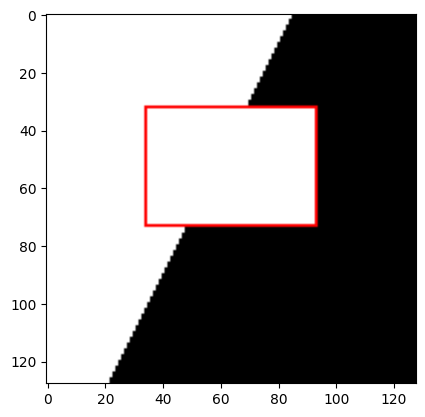

MovieWriter imagemagick unavailable; using Pillow instead.


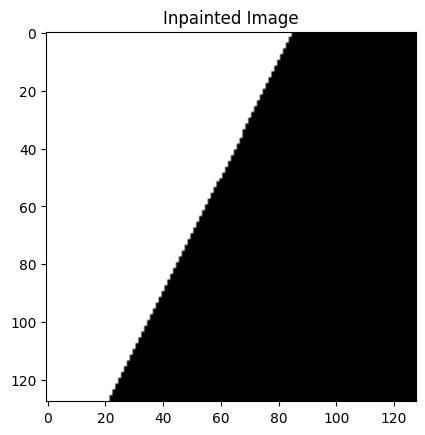

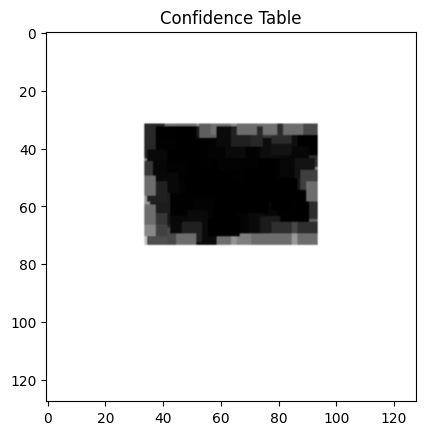

Timing stats over 119 iterations:
priorities: 5.228154799517463 ms avg, 12.019872665405273 ms max
exemplar: 25.50960989559398 ms avg, 297.29628562927246 ms max
fill: 0.04325594220842634 ms avg, 0.2391338348388672 ms max


In [56]:
image = 255 * np.ones((128, 128), dtype=int)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if (i + 2 * j >= 170):
            image[i, j] = 0

mask = np.ones((128, 128), dtype=bool)
mask[32:74, 34:94] = False
mask_with_boundary = MaskWithBoundary(mask)

overlay_mask_image(mask_with_boundary, image)

objrem = ObjectRemove(PATCH_SIZE, image)
objrem.fill_region(mask_with_boundary)